In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from utils import get_dataset, imshow, get_default_device, create_directory, save_model
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)
import torch.optim as optim
from utils import train

# AlexNet

In [2]:

class conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(conv, self).__init__()
        self.filter_bank = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.filter_bank(x)
        return x


class pooling(nn.Module):
    def __init__(self, size, stride):
        super(pooling, self).__init__()
        self.pooling = torch.nn.MaxPool2d(kernel_size=size, stride=stride)

    def forward(self, x):
        x = self.pooling(x)
        return x


class lrn(nn.Module):
    def __init__(self, neighbors):
        super(lrn, self).__init__()
        self.lrn_ = nn.LocalResponseNorm(neighbors)

    def forward(self, x):
        x = self.lrn_(x)
        return x


class linear(nn.Module):
    def __init__(self, input, output):
        super(linear, self).__init__()
        self.linear_ = nn.Sequential(
            nn.Linear(input, output),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.linear_(x)
        return x


class alexnet(nn.Module):
    def __init__(self, num_classes):
        super(alexnet, self).__init__()
        
        self.stage1 = nn.Sequential(
            conv(3, 96, 11, 4, 2),
            lrn(5),
            pooling(3, 2)
        )
        
        self.stage2 = nn.Sequential(
            conv(96, 256, 5, 1, 2),
            lrn(5),
            pooling(3, 2),
        )
        
        self.stage3 = conv(256, 384, 3, 1, 1)
        
        self.stage4 = conv(384, 384, 3, 1, 1)
        
        self.stage5 = nn.Sequential(
            conv(384, 256, 3, 1, 1),
            pooling(3, 3)
        )
        
        self.stage6 = nn.Sequential(
            linear(1024, 1024),
            linear(1024, num_classes),
            nn.Softmax(dim=1)
        )
        
        # intializing weights
        self.initialize_weights()
        
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = torch.flatten(x, 1)
        x = self.stage6(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
                        
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 1)
                    
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight)
                torch.nn.init.constant_(m.bias, 0)
        

In [3]:
NUM_CLASSES = 102
IMG_SIZE = 128
BATCH_SIZE = 128

model = alexnet(NUM_CLASSES)

# testing
input = torch.rand([10,3,IMG_SIZE,IMG_SIZE])
out = model(input)
print("input shape:", input.shape)
print("output shape:", out.shape)

input shape: torch.Size([10, 3, 128, 128])
output shape: torch.Size([10, 102])


# Entrenamiento y validacion

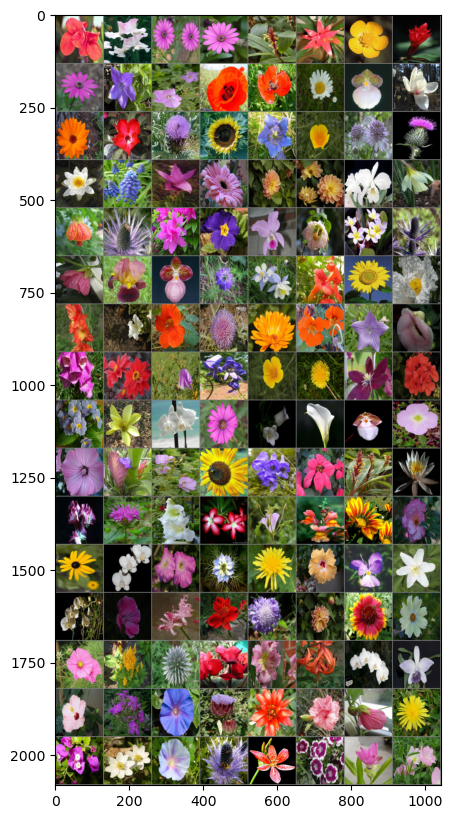

Device: cuda
######### Starting Training ########
it:0/2, Average Accuracy: 0.010116647396768843
it:1/2, Average Accuracy: 0.008928571428571428
######### Finished Training ########
Total Trainig Time[s]:  6.045640230178833 
Average Training Time per Epoch [it/s]:  3.0228201150894165 
Device: cuda


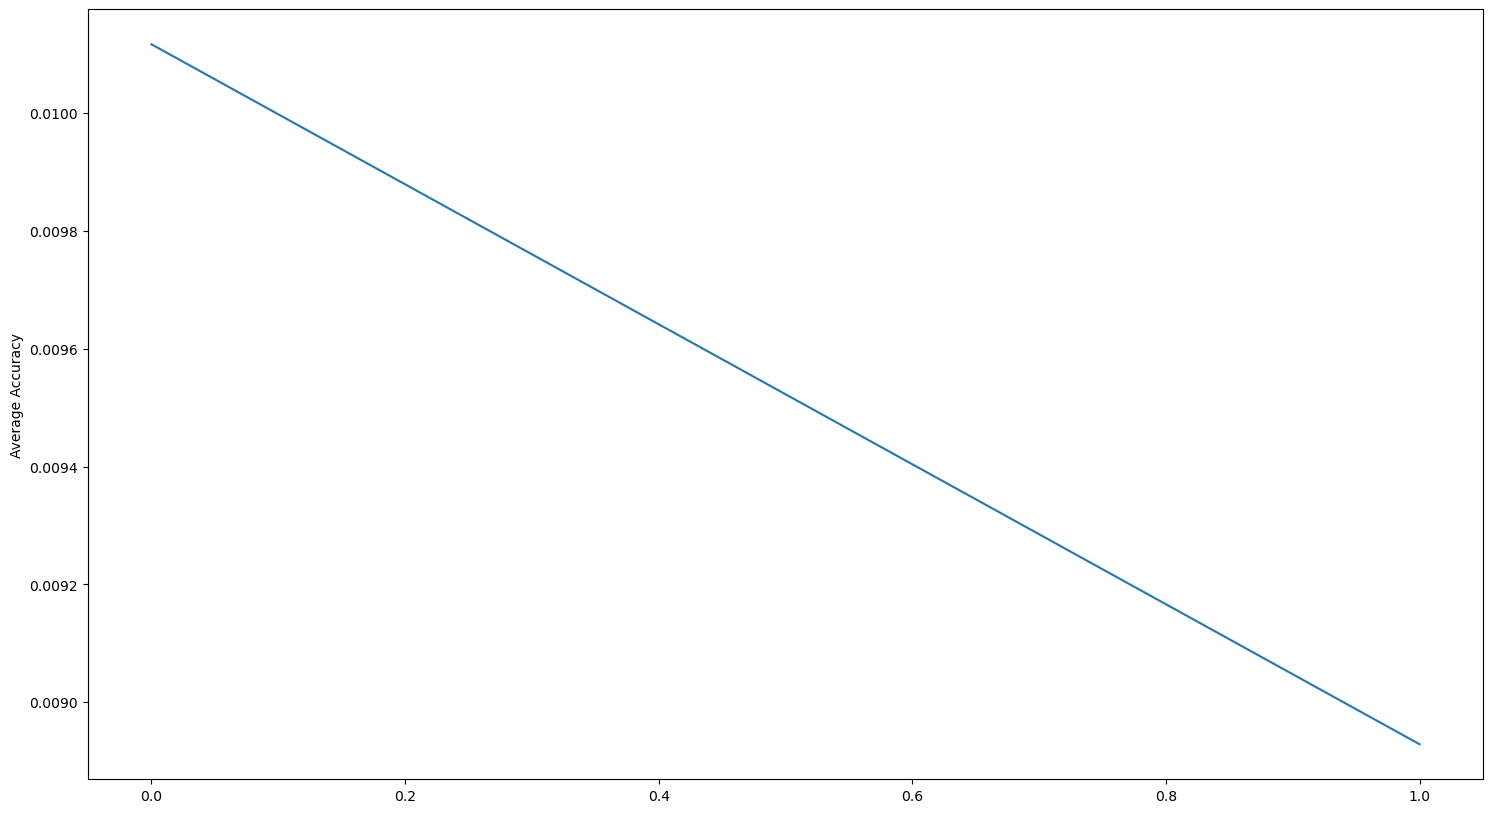

In [4]:
data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
]

trainloader, testloader = get_dataset(dataset_name='flowers102', transform=data_transforms, batchsize = BATCH_SIZE)
imshow(testloader)

device = get_default_device()
#device = torch.device('cpu')
trained_model = train(net=model,
                    epochs=2,
                    trainloader = trainloader,
                    criterion = nn.CrossEntropyLoss(),
                    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                    device = device)



In [5]:
PATH = './trained_models/alexnet'
create_directory(PATH)
save_model(PATH, model=trained_model, weights='alexnet.pth')

Directory './trained_models/alexnet' already exists.
